# Trivial example of a supervised model.

In [122]:
%load_ext autoreload
%autoreload 2
import math
import random

import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem description
We have a data set consisting of five columns of float and all we know is that the first four numbers are measurements that result to the fifth one; our objective is to see if we can somehow guess the fifth when knowing the the others.


### Our objective

We will try to find out if we can use the input that consists of the values v1, v2, v3, v4 to calculate the target.

Essentially we can think that we are trying to discover a model like the following:

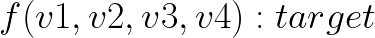

### Estimating the accuracy of the model

One question we need to answer when given a model like the one above, is to estimate how well it works. One way to do so would be to try it in data that were neven seen during the model creation and estimate the cummulative error that we are getting when applying it.


For our example, the error metric that we will use is called **Mean Squared Error** and we will reuse its **sklearn** implemenation. A quick definition of **Mean Squared Error** (MSE) is that it expresses the average of the squares of the errors and the lower it is the better our prediction.

### Data separation

To be able to accurately estimate the validity of our model, we start by spliting the full universe of the data into to two parts, one will be used to **train** our modeld ang the the other to **test** it using the **MSE** metric.  To split the data we will use the **train_test_split** function of **sklearn**. 

Another name that we can use for the inputs to the model is **features** while the output of the model can also be called **targets**.


In [50]:
# Utilities.
def plot_history(history):
    plt.clf()
    min_value, max_value = 1000, 0
    for key in history.history.keys():
        plt.plot(history.history[key], label=key)
        min_value = min(min_value, min(history.history[key]))
        max_value = max(max_value, max(history.history[key]))
    #plt.ylim([min_value, max_value])
    plt.ylim([0, max_value])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


In [130]:
# Let's assume that the data are stored in a file called my_data.csv
data = pd.read_csv("../data/my_data.csv")
data


,v1,v2,v3,v4,target
0,13.871156,70.744302,9.056146,14.037727,56.910631
1,76.159438,61.001330,16.374717,53.701238,60.228766
2,12.023961,16.364263,95.972164,30.898488,85.197092
3,59.318865,70.215681,89.355463,14.395969,63.387992
4,85.270815,42.369717,0.294042,29.457914,85.952118
...,...,...,...,...,...
9995,55.603956,86.424943,45.289957,3.244558,83.817392
9996,99.696557,48.697339,80.502594,63.341876,24.142715
9997,55.560965,95.482287,29.010972,17.817943,82.077113
9998,81.471479,85.303090,37.213704,30.477429,70.459945


MSE: 0.10514217050960982


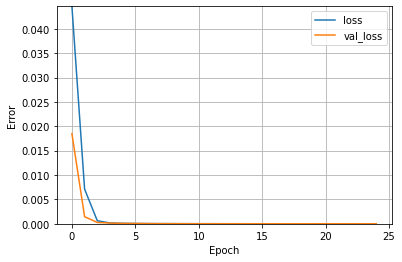

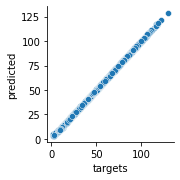

In [131]:
# Separate features and targets.
features = data.copy()
targets = pd.DataFrame(features.pop("target"))

# Split the data into training and testing subsets (20%).
X_train,X_test,y_train,y_test = train_test_split(features,targets,test_size=0.2)

# Create the necessary scalers.
x_scaler = MinMaxScaler()
x_scaler.fit(X_train)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)

# Scale the X_train.
scaled_x_train = pd.DataFrame(x_scaler.transform(X_train), columns=X_train.columns)

# Scale the Ytrain.
scaled_y_train = pd.DataFrame(y_scaler.transform(y_train), columns=y_train.columns)

# Build the model.
FEATURE_COUNT = len(X_train.columns)

model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_shape=(FEATURE_COUNT,)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(
    loss='mean_squared_error',        
    optimizer=tf.keras.optimizers.Adam(0.001)
)

# Train the model.
history = model.fit(
    scaled_x_train, scaled_y_train,
    batch_size=130,
    validation_split=0.2,
    shuffle=True, 
    verbose=0, epochs=25)

# Show the traing progress.
plot_history(history)

# Scale the Ytrain.
scaled_x_test = pd.DataFrame(x_scaler.transform(X_test), columns=X_test.columns)

# Make predictions.
predictions = model.predict(scaled_x_test)

# Inverse the predictions back to real values.
p = y_scaler.inverse_transform(predictions)
preds = pd.DataFrame(p, columns=['predicted'])

# Add the real target.
preds['targets'] = y_test.target.values

mean_squared_error = sklearn.metrics.mean_squared_error
preds['diff'] = preds.predicted - preds.targets

mse = mean_squared_error(preds.predicted, preds.targets)
print(f'MSE: {mse}')

_ = sns.pairplot(data=preds, y_vars=['predicted'], x_vars=['targets'])

In [132]:
preds

,predicted,targets,diff
0,32.999935,32.974591,0.025344
1,22.473228,22.040388,0.432840
2,14.715736,14.379971,0.335766
3,53.107300,53.291976,-0.184676
4,65.223213,64.693594,0.529619
...,...,...,...
1995,54.387417,54.095411,0.292006
1996,54.221970,54.005282,0.216688
1997,64.744698,65.167070,-0.422373
1998,59.387814,59.276800,0.111013


## Manual verification

The **my_data.csv** dataset represent the distances between random points in the plane where x <= 100 and y < 100. 

So, the following input data:


| v1| v2| v3  | v4  | t  |
|--:|--:|---|---|---|
|30.796   |56.226   |43.620   |18.7064   | 39.650  |

can be expressed as the following object:

```
{
   'x1': 30.796,
   'y1': 56.226,
   'x2': 43.620,
   'y2': 18.7064,
   'distance' : 39.650
}
```

or in geometrical representation:

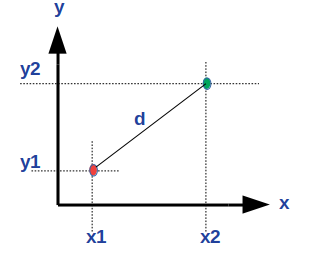

And the distance **d** is given by the following formula:

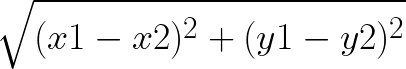

Let's write a simple function to validate the distance while using the model we've build above.

In [133]:
# x1 = float(input("x1: "))
# y1 = float(input("y1: "))
# x2 = float(input("x2: "))
# y2 = float(input("y2: "))

x1= random.uniform(0.1,99.0)
y1= random.uniform(0.1,99.0)
x2= random.uniform(0.1,99.0)
y2= random.uniform(0.1,99.0)

real_distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# Scale the Ytrain.
features = pd.DataFrame(x_scaler.transform([ [x1, y1, x2, y2]  ]), columns=X_test.columns)

# Make predictions.
predictions = model.predict(features)
estimated_distance = y_scaler.inverse_transform(predictions)[0][0]

print(f"real distance  ......: {real_distance:10.4}")
print(f"estimated distance ..: {estimated_distance:10.4}")


real distance  ......:      86.57
estimated distance ..:      86.37


# Conclusion

* A supervised model receives a universe of input data and their expected results. 
* The data are split in training and testing subsets. 
* We create and train the model having as objective to minimize the error in unseen data.


